# vix index prediction - based on PCA+LSTM

The idea of this project is as follows\
1 More than 20 technical indicators are calculated using the volume and price data of SP500 index, including opening, closing, high, low and trading volume. The time frame of the data is from January 1, 2023 to March 28, 2025.\
2. Use PCA to downsize the technical indicators, so that the eight principal components can replace the original more than 30 volume and technical indicators.\
3 Use data from January 2023 to December 2024 as the training set and data from January to March 2025 as the test set.\
4 Use LSTM model forecasting to predict the next day's vix using the principal component data from the previous trading day and find the best model parameters\
5 Predict and compare with real vix on validation set.

#### All the functions of this project are encapsulated in the functions.py file, which implements all the data processing and prediction methods of this paper

In [16]:
import function as f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

In [17]:
path = './data.csv'
data = f.import_data(path)
data.head()

,close,high,low,open,volume,vix
date,,,,,,
2023-01-03,3824.139893,3878.459961,3794.330078,3853.290039,3959140000,22.90
2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000,22.01
2023-01-05,3808.100098,3839.739990,3802.419922,3839.739990,3893450000,22.46
2023-01-06,3895.080078,3906.189941,3809.560059,3823.370117,3923560000,21.13
2023-01-09,3892.090088,3950.570068,3890.419922,3910.820068,4311770000,21.97


    plot_close_vix implements the plotting of the closing price and vix index data, and you can see that the closing price is in a downtrend when the vix index is rising

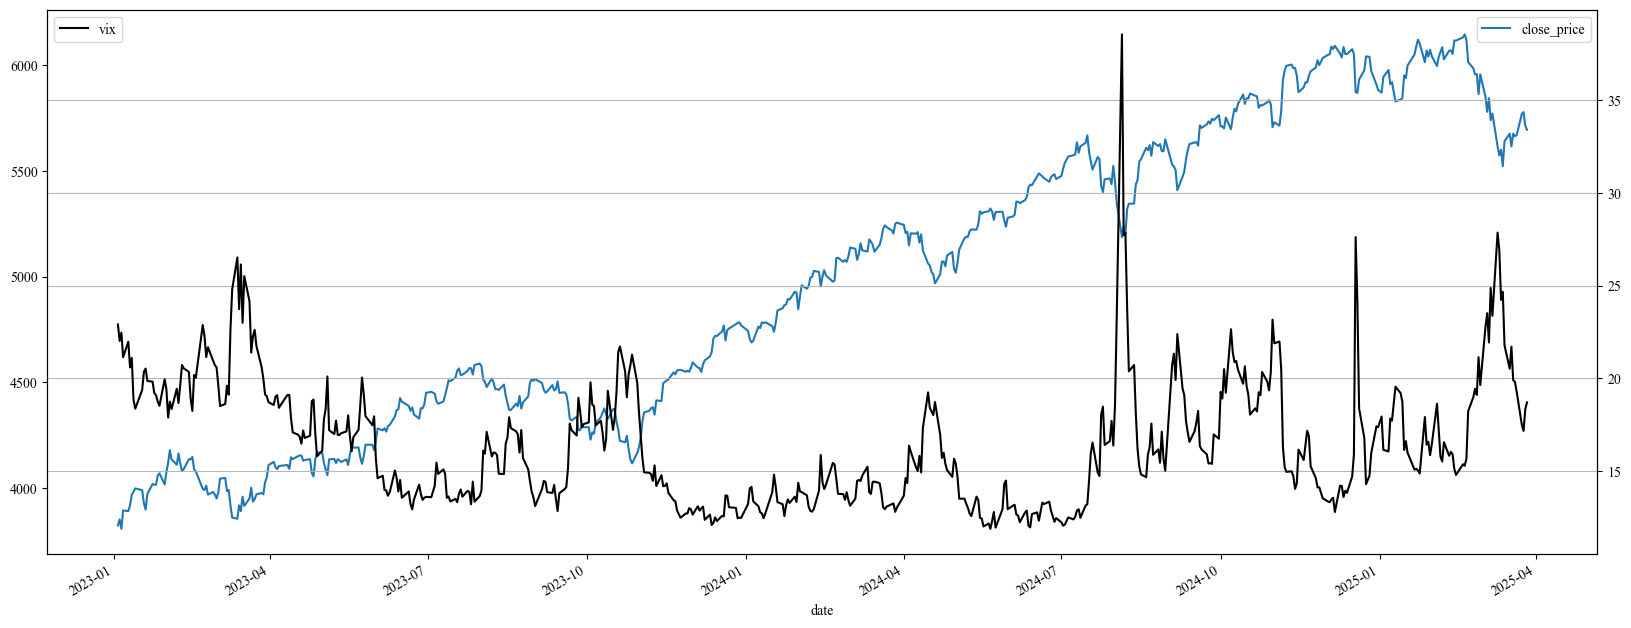

In [18]:
f.plot_close_vix(data)

    calculate_technical_indicators implements more than 20 technical indicators, which can be found in the py file, and plot_corr implements the thermal matrix of the correlation coefficients

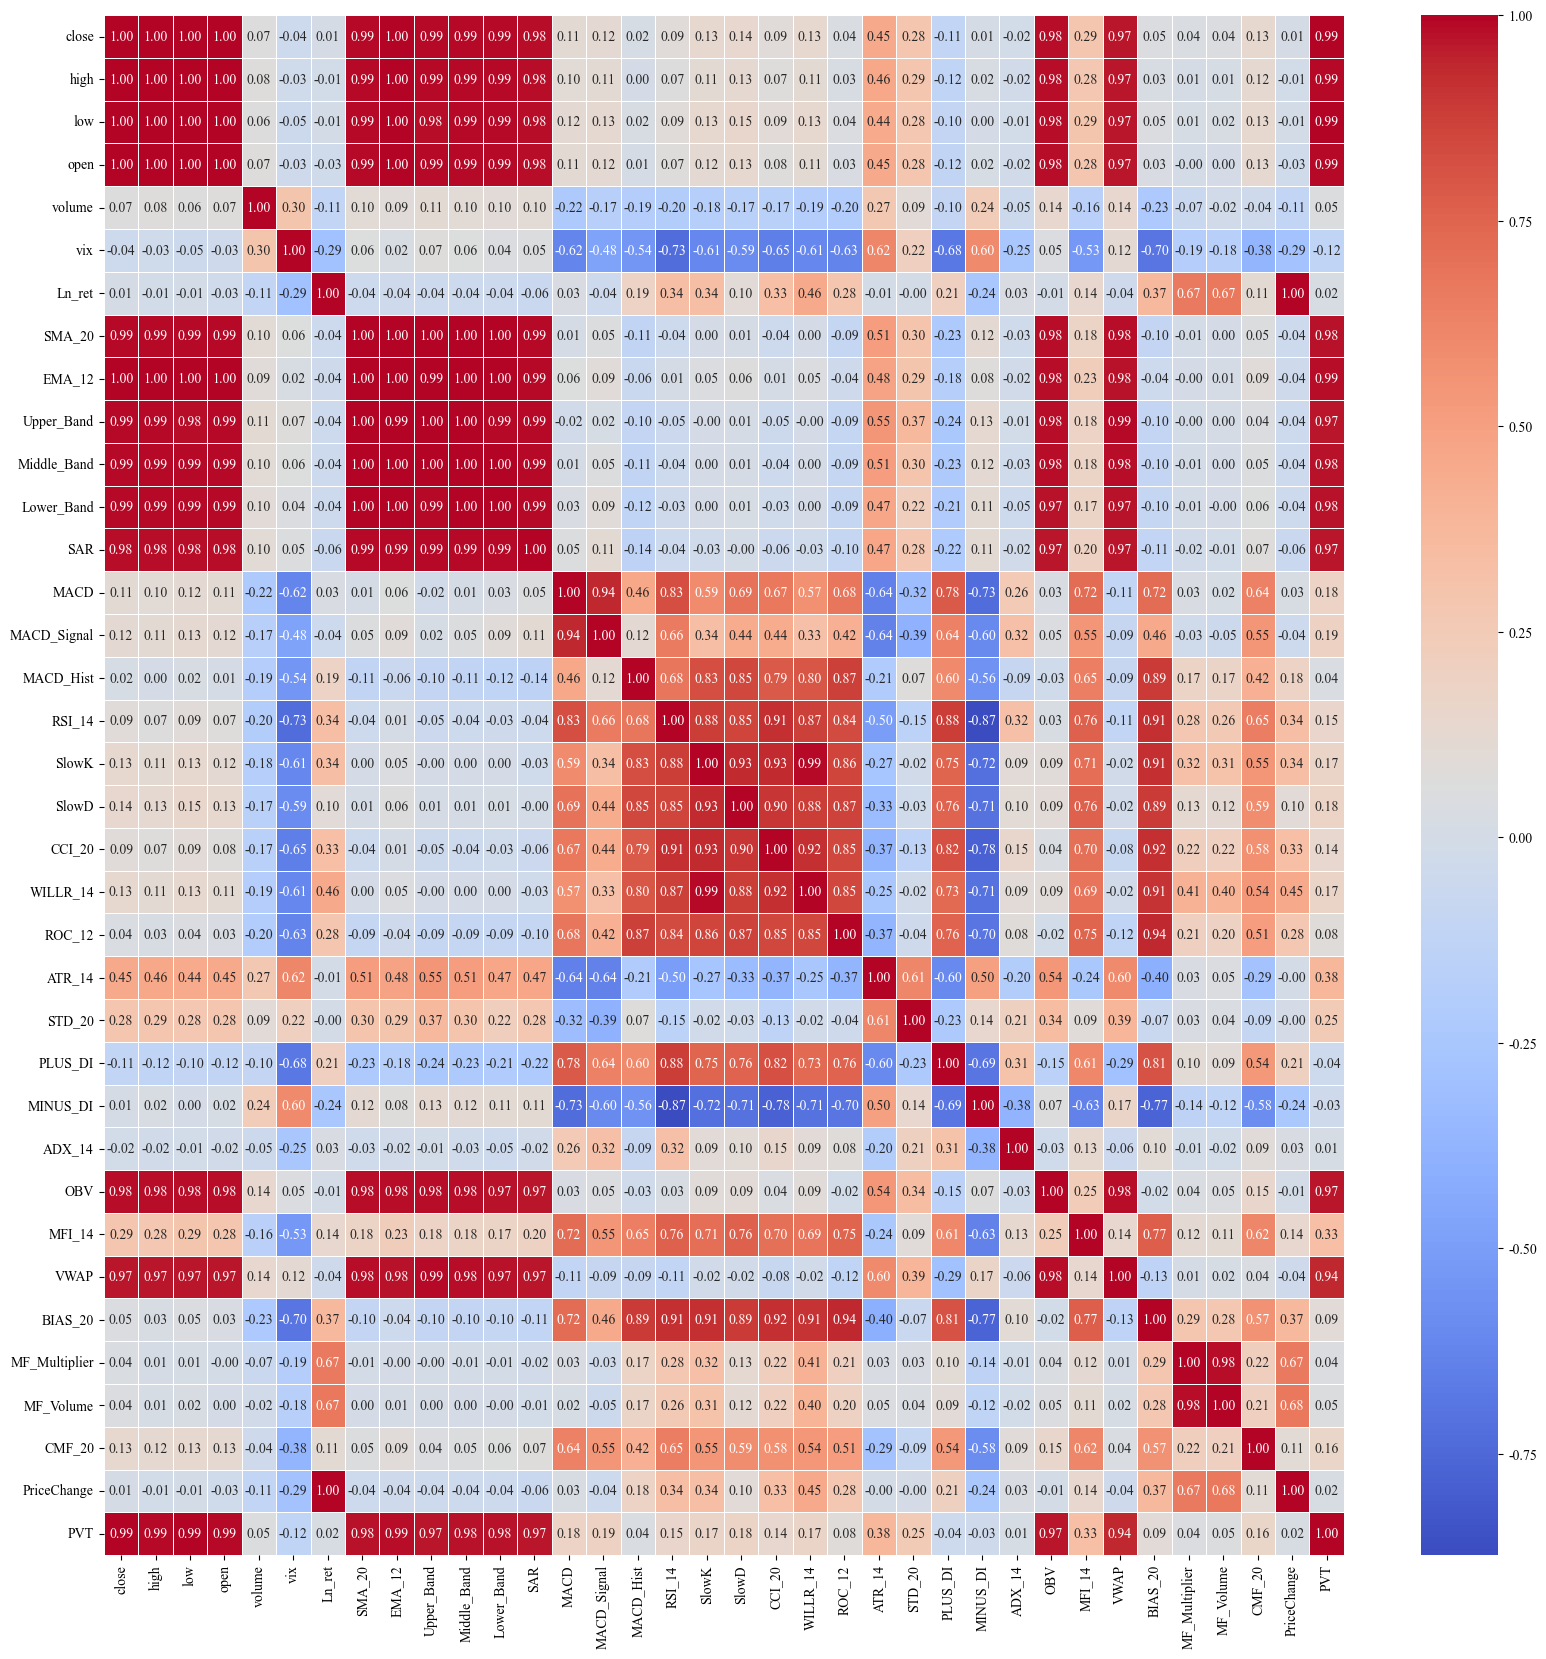

In [19]:
data = f.calculate_technical_indicators(data)
f.plot_corr(data)

In [21]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
close,526.0,5.024423e+03,6.738108e+02,3.855760e+03,4.404675e+03,5.069645e+03,5.625965e+03,6.144150e+03
high,526.0,5.047198e+03,6.766853e+02,3.894260e+03,4.421975e+03,5.091935e+03,5.650265e+03,6.147430e+03
low,526.0,4.998770e+03,6.707666e+02,3.808860e+03,4.383340e+03,5.043425e+03,5.593002e+03,6.111150e+03
open,526.0,5.023800e+03,6.750150e+02,3.835120e+03,4.405070e+03,5.071785e+03,5.629257e+03,6.134500e+03
volume,526.0,4.056058e+09,8.442337e+08,1.639500e+09,3.596805e+09,3.878925e+09,4.301045e+09,9.367460e+09
vix,526.0,1.625468e+01,3.348216e+00,1.186000e+01,1.363500e+01,1.547000e+01,1.818500e+01,3.857000e+01
Ln_ret,526.0,6.401717e-04,8.223577e-03,-3.042704e-02,-3.780034e-03,8.788181e-04,5.731983e-03,2.498128e-02
SMA_20,526.0,4.996018e+03,6.743206e+02,3.954390e+03,4.385178e+03,5.057701e+03,5.571167e+03,6.073114e+03
EMA_12,526.0,5.007611e+03,6.727917e+02,3.941070e+03,4.398920e+03,5.070829e+03,5.578944e+03,6.091330e+03
Upper_Band,526.0,5.135584e+03,6.929002e+02,4.054718e+03,4.539762e+03,5.171272e+03,5.753697e+03,6.271903e+03


    For data slicing, the predicted data for this project is the vix index, and the characteristic variables are all the remaining variables except vix. The feature variables were downscaled using the perform_pca method and the cumulative contribution curve was plotted using visualize_variance. It can be seen that when the number of principal components is 8, the cumulative contribution reaches 95%.

In [5]:
y = data.vix
x = data[data.columns.drop('vix')]
pca_model,pca_data = f.perform_pca(x)

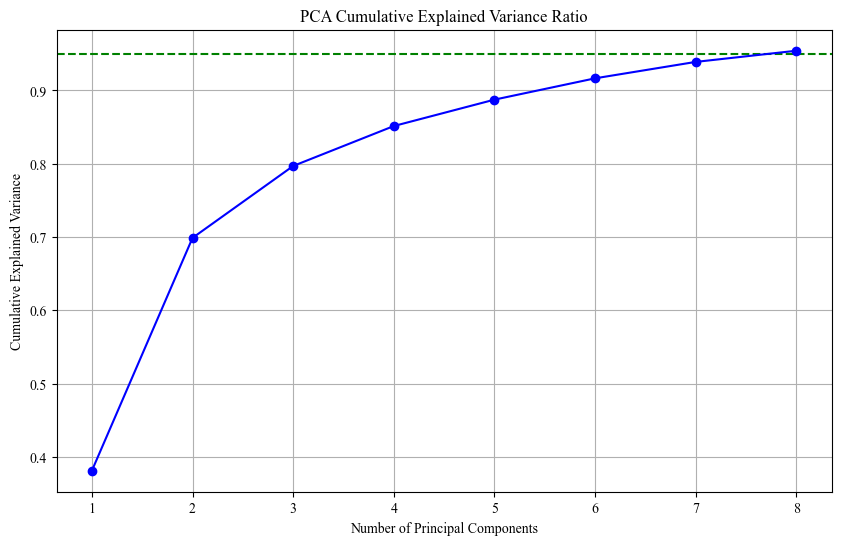

In [6]:
f.visualize_variance(pca_model)

    The plot_pca_loadings method calculates the factor loading matrices of the principal components and plots their heat maps

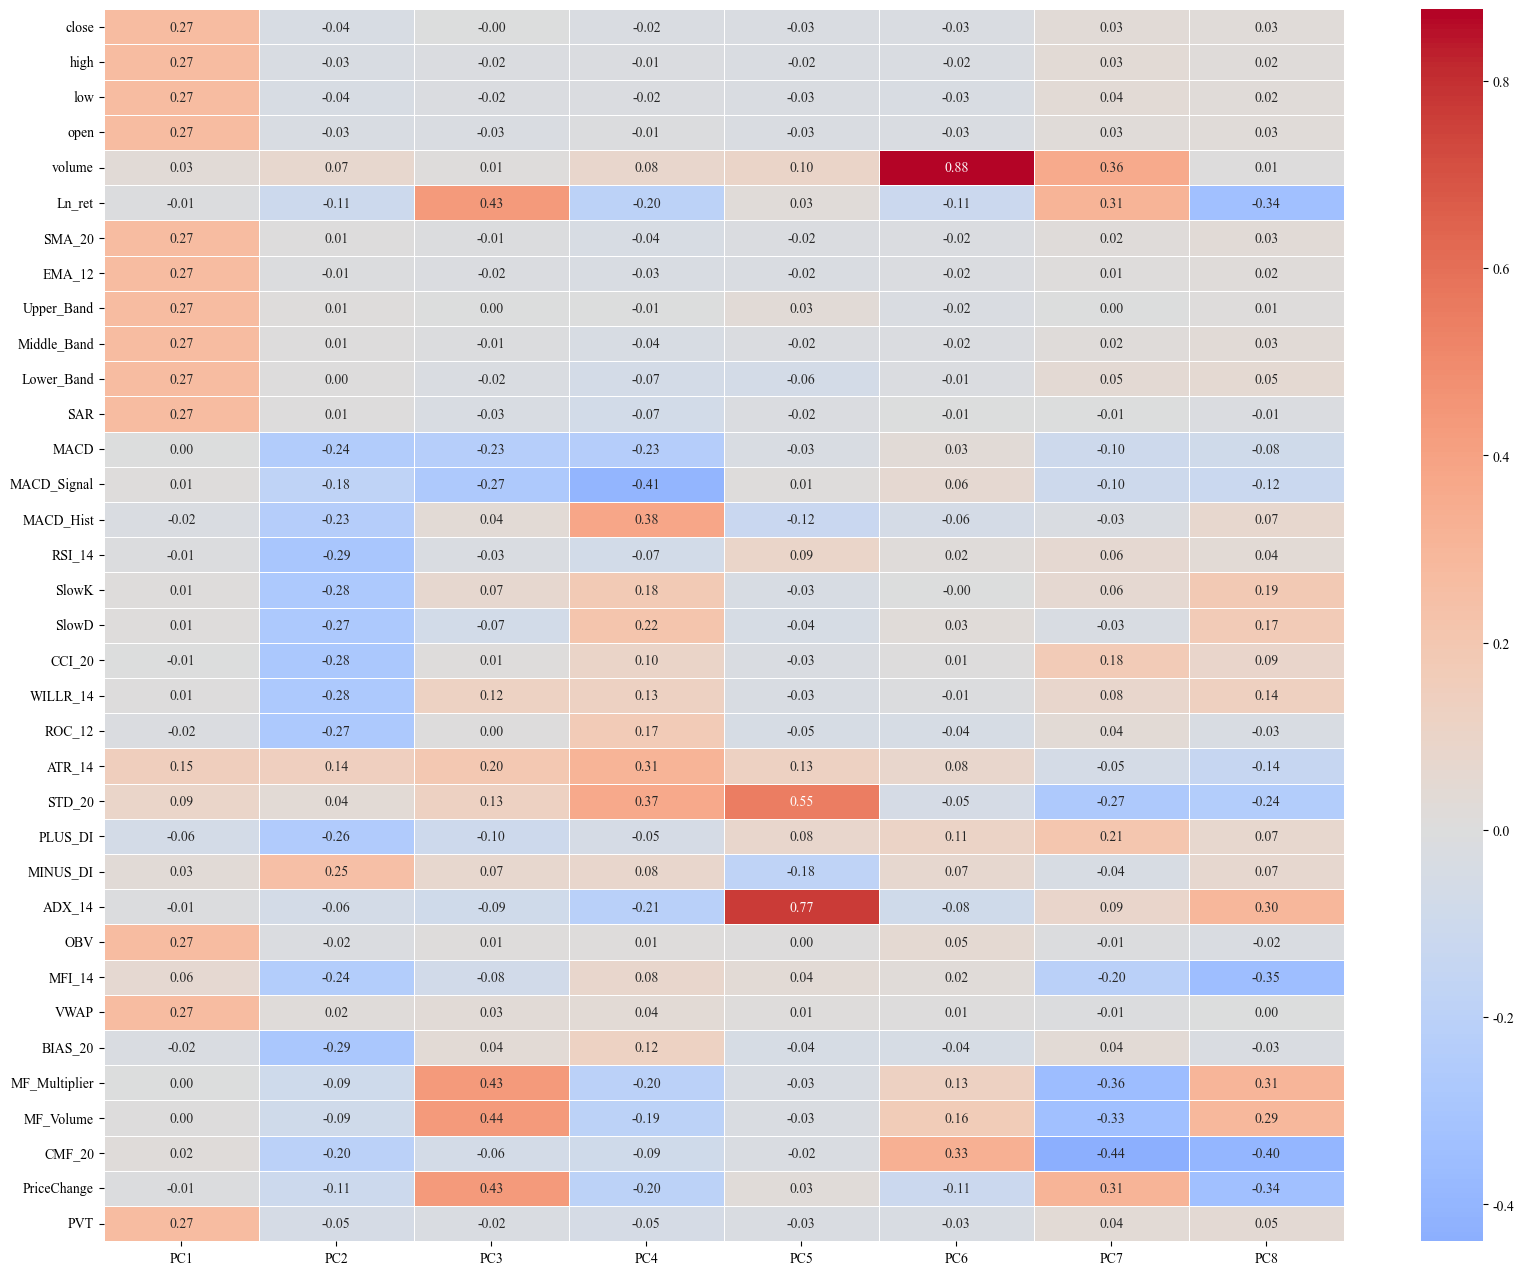

In [7]:
f.plot_pca_loadings(pca_model,x)

In [8]:
data = pd.concat([y,pca_data],axis=1)
data.head()

,vix,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
date,,,,,,,,,
2023-02-22,22.87,-4.777648,4.341744,-4.300015,-0.995406,0.915959,0.939603,-1.476083,-0.411287
2023-02-23,22.29,-4.929422,4.274528,-1.233244,-2.263507,0.817345,0.532440,-0.592226,-1.249602
2023-02-24,21.14,-4.939242,3.551473,0.740056,-2.754818,0.623055,0.442833,-0.721338,-0.993239
2023-02-27,21.67,-4.952591,4.872776,-0.693642,-2.000777,0.520243,0.825926,-2.237174,0.273174
2023-02-28,20.95,-4.972210,4.159457,-0.695224,-1.511797,0.691065,-0.148797,0.182438,-1.903518


In [9]:
data.shape

(526, 9)

In [10]:
data.describe().round(2)

,vix,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
count,526.00,526.00,526.00,526.00,526.00,526.00,526.00,526.00,526.00
mean,16.25,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
std,3.35,3.65,3.34,1.86,1.38,1.12,1.01,0.89,0.73
min,11.86,-5.47,-5.70,-5.27,-3.41,-2.62,-2.83,-2.75,-2.07
25%,13.64,-3.44,-2.69,-1.32,-0.98,-0.80,-0.62,-0.59,-0.47
50%,15.47,0.21,-0.92,-0.03,-0.18,-0.18,-0.13,-0.02,0.03
75%,18.18,3.26,2.43,1.30,0.95,0.68,0.41,0.60,0.47
max,38.57,5.91,9.51,6.15,4.62,4.13,5.49,3.30,2.91


    Cut the training set and validation set, and use the normalization function to transform the input data to achieve a more accurate prediction, it should be noted that the subsequent lstm network output is also the result of the normalization, you need to retain the original normalization function, the subsequent prediction of the data to do the anti-normalization

In [11]:
train_time_length = len(data[:'2024-12-31'])
test_time_length = len(data['2025-01-01':])
real_y = data['2025-01-01':].vix

X = data[data.columns.drop('vix')]
Y = data[['vix']]

xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
X = xScaler.fit_transform(X)
Y = yScaler.fit_transform(Y)
X = X.reshape((len(X),1,8))
Y = Y.reshape(len(X),1)

xTrain,yTrain = X[:train_time_length],Y[:train_time_length]
xTest,yTest = X[train_time_length:],Y[train_time_length:]

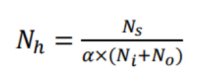

    Where Nh, Ni,No denote the number of neurons in the hidden layer, the number of neurons in the input layer, and the number of neurons in the output layer, respectively, N, denotes the number of samples in the training set, and α is a constant that can be taken as 2-10.

Nh=526/(a*9), Nh is between 5-30

    Cut the training set and validation set, and use the normalization function to do the transformation of the input data, has reached a more accurate prediction effect, it should be noted that the subsequent lstm network output is also the result of the normalization, you need to retain the original normalization function, and the subsequent prediction of the data to do the anti-normalization.
    The loss_result method implements several prediction error evaluation methods including MSE, RMSE, MAE, R2, MPEA.

In [12]:
lstm_out_put = {}
Nhs = [5,10,15,20,25,30]
for Nh in Nhs:
    lstm = f.buildLSTM(Nh, learnRate=0.001)

    epochs = 500
    batchSize = 64
    lstm.fit(xTrain,yTrain,epochs=epochs,batch_size=batchSize,verbose=0)

    lstm_pred = lstm.predict(xTest)
    lstm_pred = yScaler.inverse_transform(lstm_pred)[:,0]
    lstm_out_put[Nh] = f.loss_result(lstm_pred,real_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [13]:
select_params = pd.DataFrame(lstm_out_put)
select_params

,5,10,15,20,25,30
MSE,3.008319,4.127252,4.124490,3.820328,4.117774,4.431629
RMSE,1.734451,2.031564,2.030884,1.954566,2.029230,2.105144
MAE,1.527177,1.821006,1.805328,1.725069,1.798974,1.874226
R_2,0.631474,0.518733,0.547411,0.577466,0.551572,0.526982
MAPE,8.615294,10.281933,10.169235,9.701184,10.125144,10.543472


    Optimal LSTM model with 20 hidden layer neurons according to the output of lsss_result

In [22]:
lstm = f.buildLSTM(20, learnRate=0.001)

epochs = 500 
batchSize = 64 
lstm.fit(xTrain,yTrain,epochs=epochs,batch_size=batchSize,verbose=0)

lstm_pred = lstm.predict(xTest)
lstm_pred = yScaler.inverse_transform(lstm_pred)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


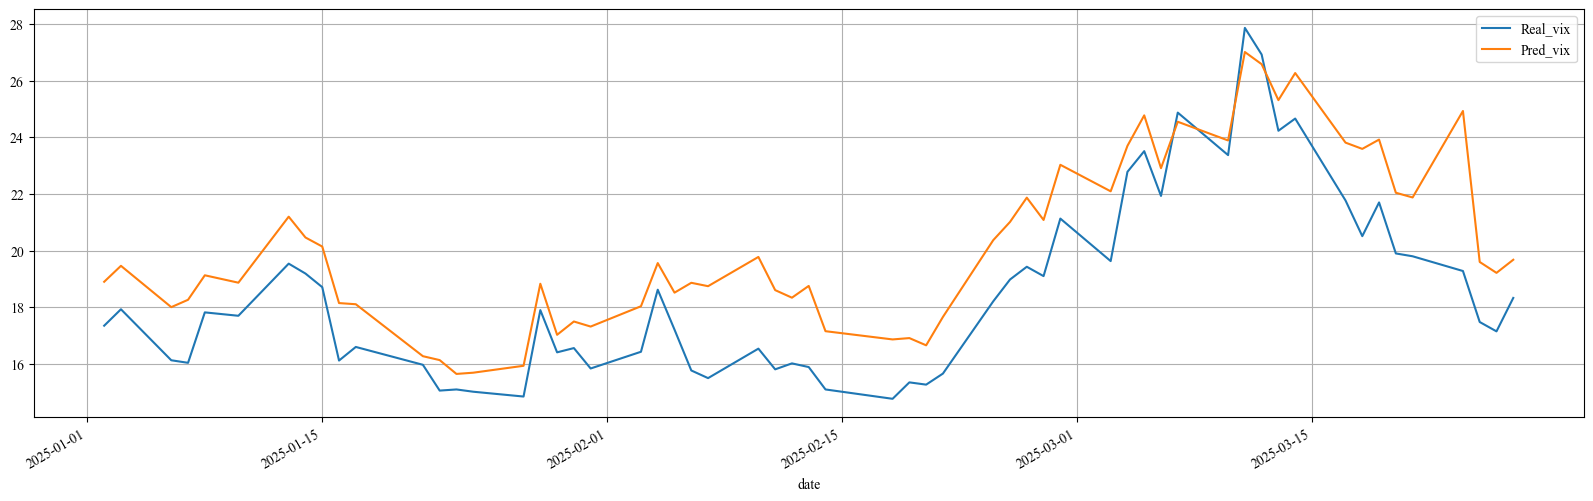

In [23]:
lstm_result = {'Real_vix':real_y,'Pred_vix':lstm_pred}
lstm_result = pd.DataFrame(lstm_result)
lstm_result.plot(figsize=(20,6))
plt.legend()
plt.grid()